ENEDIS - Machine Learning Evaluation des modèles, sélection et test du modèle

Contenu:
* Partie I: evaluation des modèles avec seulement deux régions
* Partie II: Entraînement du modèle selectionnée (RandomForestRegressor) avec les 12 régions  et test de prédiction

### Bibliothèque

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
# Importer SimpleImputer pour gérer les valeurs NaN
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  V1 : Récupération du df  Deux Régions 
- REGION_CVL_HF_FULL

In [ ]:
#df_conso_meteo= pd.read_csv("/content/drive/MyDrive/df_hf_cvl_full.csv", sep = ',')
df_conso_meteo= pd.read_csv("https://drive.google.com/uc?export=view&id=1-MESKGsp48qZbEYwMeb4mKxHSo39F82T", sep = ',')

display(df_conso_meteo.head())

,DATE,REGION,CODE,NB_POINTS_SOUTIRAGE,ENERGIE_SOUTIREE,Date,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,...,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,OPINION,SUNSET,SUNRISE,Vacances
0,2022-01-01,Centre-Val de Loire,24,68742328,2.729271e+10,2022-01-01,13.0,8.0,12.0,0.0,...,10.0,1026.0,44.0,13.0,8.000000,6.0,météo correcte,17:10:00,08:36:00,0
1,2022-01-02,Centre-Val de Loire,24,68737232,2.793946e+10,2022-01-02,14.0,9.0,24.0,0.0,...,10.0,1025.0,66.0,14.0,10.666667,8.0,météo correcte,17:11:00,08:36:00,0
2,2022-01-03,Centre-Val de Loire,24,68750372,2.820313e+10,2022-01-03,12.0,10.0,22.0,1.0,...,9.0,1023.0,86.0,12.0,10.166667,8.0,météo défavorable,17:12:00,08:36:00,0
3,2022-01-04,Centre-Val de Loire,24,68755474,2.926651e+10,2022-01-04,14.0,4.0,41.0,5.0,...,9.0,1015.0,78.0,14.0,9.500000,9.0,météo défavorable,17:13:00,08:36:00,0
4,2022-01-05,Centre-Val de Loire,24,68759686,3.375534e+10,2022-01-05,7.0,1.0,22.0,2.0,...,9.0,1023.0,48.0,7.0,5.166667,-2.0,météo très défavorable,17:14:00,08:36:00,0


## Preprocessing

In [ ]:
# Convertir la colonne 'Date' en type datetime
df_conso_meteo['DATE'] = pd.to_datetime(df_conso_meteo['DATE'])

# Extraire le jour et le mois
df_conso_meteo['Jour'] = df_conso_meteo['DATE'].dt.day
df_conso_meteo['Mois'] = df_conso_meteo['DATE'].dt.month

# Supprimer la colonne 'Date' car pas utile
df_conso_meteo.drop(columns=['Date'], inplace=True)

# Afficher les premières lignes pour vérifier
# display(df_conso_meteo.head())

# # Conversion des colonnes SUNSET et SUNRISE en format datetime
df_conso_meteo['SUNRISE'] = pd.to_datetime(df_conso_meteo['SUNRISE'], format='%H:%M:%S')
df_conso_meteo['SUNSET'] = pd.to_datetime(df_conso_meteo['SUNSET'], format='%H:%M:%S')

# Calcul de la longueur du jour
df_conso_meteo['Day Length'] = (df_conso_meteo['SUNSET'] - df_conso_meteo['SUNRISE']).dt.total_seconds() / 3600  # En heures

# # Suppression des colonnes SUNRISE et SUNSET
# df = df_conso_meteo.drop(columns=['SUNRISE', 'SUNSET'])

# Vérification du résultat
# display(df_conso_meteo)
# Application du One-Hot Encoding à la colonne OPINION
df_encoded = pd.get_dummies(df_conso_meteo, columns=['OPINION'])

# One-Hot Encoding pour la colonne 'Région'
df_encoded = pd.get_dummies(df_encoded, columns=['REGION'])


# Sélection des colonnes météorologiques et des colonnes encodées
cols_meteo = ['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
              'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
              'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
              'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'SUNSET', 'SUNRISE', 'Day Length']

opinion_dummies = [col for col in df_encoded.columns if col.startswith('OPINION_')]
region_dummies = [col for col in df_encoded.columns if col.startswith('REGION_')]

# Inclure les colonnes météorologiques et les colonnes d'OPINION encodées
cols_to_plot = cols_meteo + opinion_dummies + region_dummies

# Filtrer le DataFrame pour inclure uniquement ces colonnes
df_meteo_opinion = df_encoded[cols_to_plot]



In [ ]:
df_conso_meteo.columns

Index(['DATE', 'REGION', 'CODE', 'NB_POINTS_SOUTIRAGE', 'ENERGIE_SOUTIREE',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'OPINION', 'SUNSET', 'SUNRISE',
       'Vacances', 'Jour', 'Mois', 'Day Length'],
      dtype='object')

## Correlation

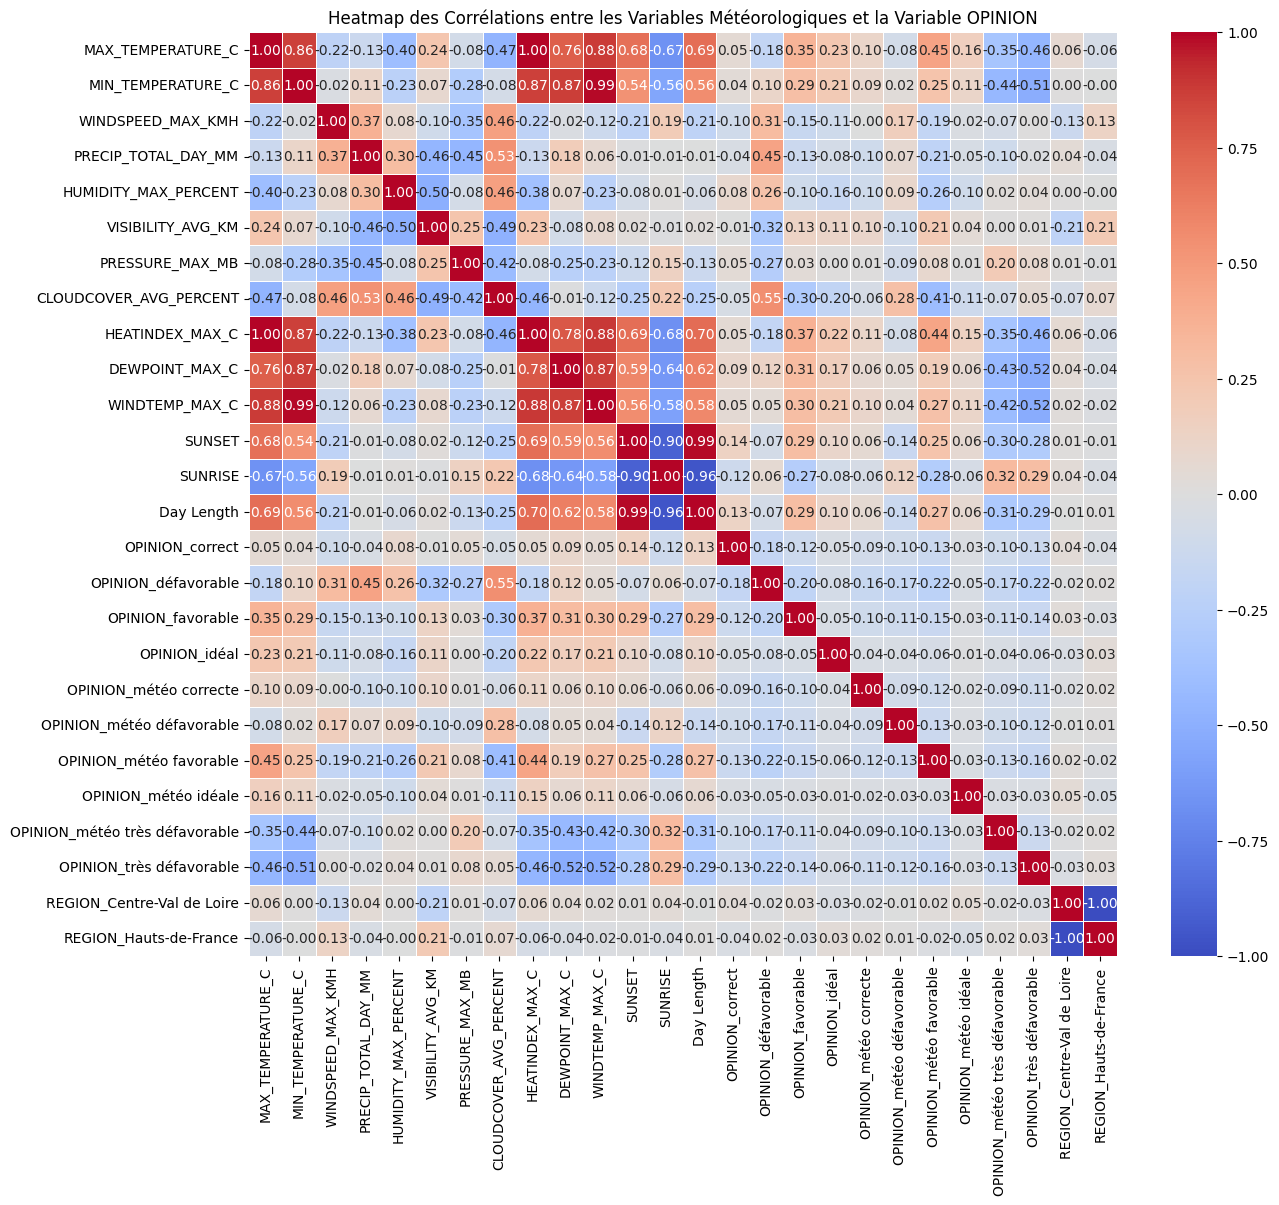

Fichier transformé et sauvegardé sous 'df_encoded_transformed.csv'


In [ ]:

# Calcul de la matrice de corrélation
corr_matrix_meteo_opinion = df_meteo_opinion.corr()

# Sauvegarde du DataFrame transformé dans un fichier CSV
# df_encoded.to_csv('df_encoded_transformed.csv', index=False)

# Création de la heatmap pour visualiser les corrélations
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_meteo_opinion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap des Corrélations entre les Variables Météorologiques et la Variable OPINION')
plt.show()

print("Fichier transformé et sauvegardé sous 'df_encoded_transformed.csv'")

# display(df_encoded.head())


In [ ]:
df_encoded.columns

Index(['DATE', 'CODE', 'NB_POINTS_SOUTIRAGE', 'ENERGIE_SOUTIREE',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'SUNSET', 'SUNRISE', 'Vacances',
       'Jour', 'Mois', 'Day Length', 'OPINION_correct', 'OPINION_défavorable',
       'OPINION_favorable', 'OPINION_idéal', 'OPINION_météo correcte',
       'OPINION_météo défavorable', 'OPINION_météo favorable',
       'OPINION_météo idéale', 'OPINION_météo très défavorable',
       'OPINION_très défavorable', 'REGION_Centre-Val de Loire',
       'REGION_Hauts-de-France'],
      dtype='object')

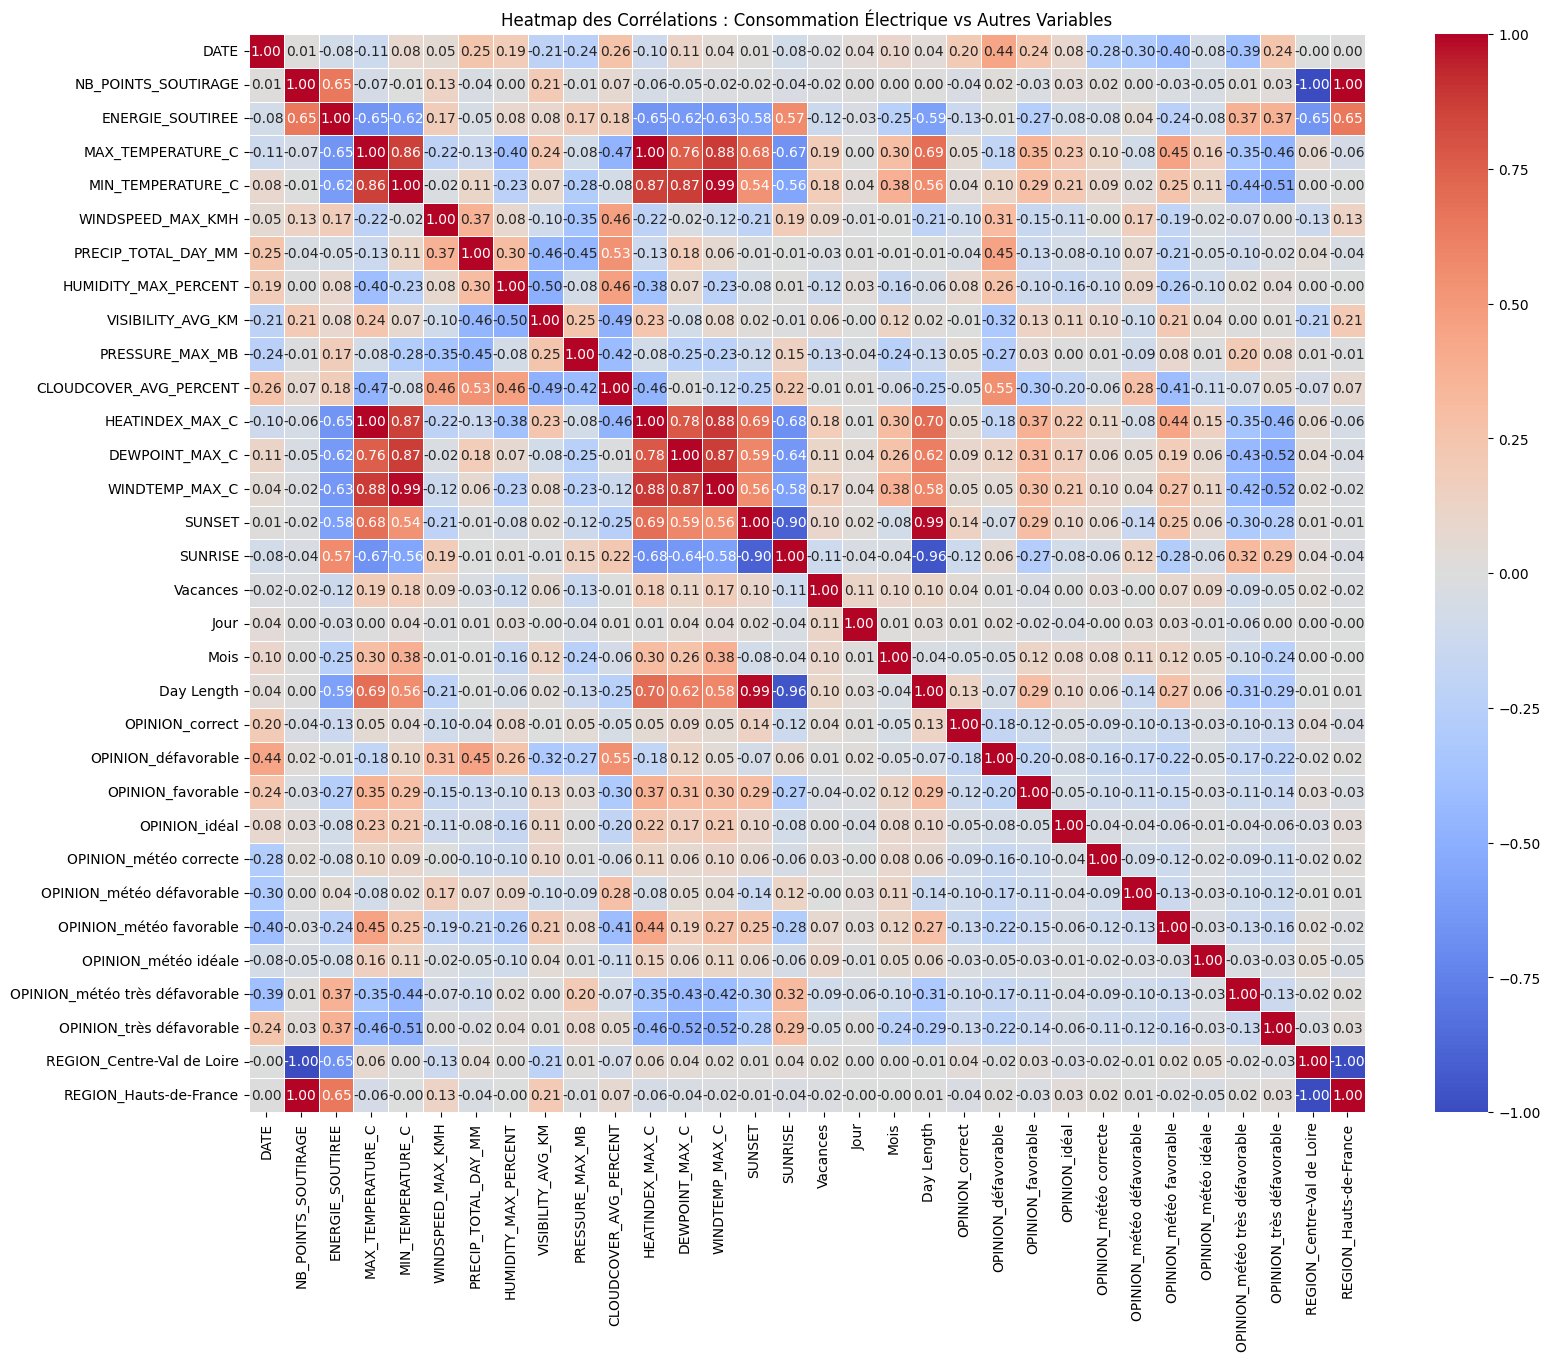

In [ ]:
# Liste des colonnes à inclure pour évaluer la consommation électrique
# Ajoutez ou retirez des colonnes selon vos besoins
cols_interesting = [
       'DATE', 'NB_POINTS_SOUTIRAGE', 'ENERGIE_SOUTIREE',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'SUNSET', 'SUNRISE', 'Vacances',
       'Jour', 'Mois', 'Day Length', 'OPINION_correct', 'OPINION_défavorable',
       'OPINION_favorable', 'OPINION_idéal', 'OPINION_météo correcte',
       'OPINION_météo défavorable', 'OPINION_météo favorable',
       'OPINION_météo idéale', 'OPINION_météo très défavorable',
       'OPINION_très défavorable', 'REGION_Centre-Val de Loire', 'REGION_Hauts-de-France',
]

# Filtrer le DataFrame pour inclure uniquement ces colonnes
df_interesting =  df_encoded[cols_interesting]

# Calcul de la matrice de corrélation
corr_matrix_interesting = df_interesting.corr()

# Affichage de la matrice de corrélation
# print(corr_matrix_interesting)

# Création de la heatmap pour visualiser les corrélations
plt.figure(figsize=(18, 14))
# plt.savefig('mon_graphique.png')
sns.heatmap(corr_matrix_interesting, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap des Corrélations : Consommation Électrique vs Autres Variables')
plt.show()




In [ ]:
df_encoded.columns

Index(['DATE', 'CODE', 'NB_POINTS_SOUTIRAGE', 'ENERGIE_SOUTIREE',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'SUNSET', 'SUNRISE', 'Vacances',
       'Jour', 'Mois', 'Day Length', 'OPINION_correct', 'OPINION_défavorable',
       'OPINION_favorable', 'OPINION_idéal', 'OPINION_météo correcte',
       'OPINION_météo défavorable', 'OPINION_météo favorable',
       'OPINION_météo idéale', 'OPINION_météo très défavorable',
       'OPINION_très défavorable', 'REGION_Centre-Val de Loire',
       'REGION_Hauts-de-France'],
      dtype='object')

# Partie I: Evaluation des modèles (deux régions)

##Test 1 Avec 'Nb de points de soutirage'

In [ ]:
# Liste des colonnes pertinentes pour les caractéristiques (X) avec 'Nb points soutirage'
cols_features = [
    'NB_POINTS_SOUTIRAGE', 'Jour', 'Mois', 'REGION_Centre-Val de Loire',
    'REGION_Hauts-de-France', 'Vacances', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C',
    'WINDSPEED_MAX_KMH', 'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
    'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C',
    'WINDTEMP_MAX_C', 'Day Length'
]

# Sélection des caractéristiques (X) et de la cible (y) - Total énergie soutirée (Wh)
X = df_encoded[cols_features]
y = df_encoded['ENERGIE_SOUTIREE']

# Standardisation des données
scaler_X = StandardScaler()
# Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)
X_scaled = scaler_X.fit_transform(X_imputed)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Division des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
    #'Elastic Net 0.5-L1 0.1': ElasticNet(alpha=0.5, l1_ratio=0.1),
     #'Elastic Net 1-L1 0.5': ElasticNet(alpha=1.0, l1_ratio=0.5),
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))

    results[name] = {'MSE': mse, 'R2 Train': r2_train, 'R2 Test': r2_test,'Score Train': train_score, 'Score Test': test_score}

# Affichage des résultats
for name, metrics in results.items():
    print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")
    #print(f"{name} - Score Train:{metrics['Score Train']}, ScoreTest: {metrics['Score Test']}")


Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 0.015755675963995134 *R2 Train: 0.9970055170460432 *R2 Test: 0.9844396639176822
*Gradient Boosting  *MSE: 0.016806804333475887 *R2 Train: 0.9901796578861448 *R2 Test: 0.9834015675051795
*Elastic Net  *MSE: 0.09551893299098899 *R2 Train: 0.9130483489135146 *R2 Test: 0.9056653168698894
*K-Nearest Neighbors  *MSE: 0.030096566504019456 *R2 Train: 0.9726196338415452 *R2 Test: 0.970276572658859


### Optimisation Elasticnet GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Faire une recherche Gridsearchcv pour le modèle elasticnet (alpha et L1 ratio hyperparams optimisation)
gridsearch_params = {
    # 'alpha': [0.1,0.2,0.3,0.4, 0.5, 1.0],
    # 'l1_ratio': [0.1, 0.5, 1.0]
    'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
    'l1_ratio' : np.arange(0, 1, 0.01)
}
model = ElasticNet()
grid = GridSearchCV(model, gridsearch_params, scoring='r2', cv=10)
grid.fit(X_train, y_train)
Y_pred = grid.predict(X_test)
print("Best model params: ",grid.best_params_)
print("Best model score: ",grid.best_score_)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+01, tolerance: 1.335e-01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e+01, tolerance: 1.306e-01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e+01, tolerance: 1.304e-01

Best model params:  {'alpha': 0.001, 'l1_ratio': 0.23}
Best model score:  0.9106813824403048


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.454e-01



In [ ]:
print("Best elasticnet model params: ",grid.best_params_)
print("Best elasticnet model score: ",grid.best_score_)

Best elasticnet model params:  {'alpha': 0.001, 'l1_ratio': 0.23}
Best elasticnet model score:  0.9106813824403048


### Courbe Predictions Consommation Electrique  Vs valeurs réelles

In [ ]:
def plot_predictions(y_test, X_test, model):
  # Faire des prédictions avec chaque modèle sur l'ensemble de test
  predictions = {}
  for name, model in models.items():
      predictions[name] = model.predict(X_test)

  # Créer un DataFrame pour visualiser les prédictions et la cible réelle
  df_viz = pd.DataFrame({
      'ENERGIE_SOUTIREE_REELLE': y_test,  # Données réelles (échelle standardisée)
      'Random Forest': predictions['Random Forest'],
      'Gradient Boosting': predictions['Gradient Boosting'],
      'Elastic Net': predictions['Elastic Net'],
      'K-Nearest Neighbors': predictions['K-Nearest Neighbors']
  })

  # Visualisation des prédictions versus les valeurs réelles de l'énergie soutirée
  sns.set_palette("bright")
  plt.figure(figsize=(12, 8))

  # Ajout des courbes de prédictions des différents modèles
  sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Random Forest', data=df_viz, label='Random Forest')
  sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Gradient Boosting', data=df_viz, label='Gradient Boosting')
  sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Elastic Net', data=df_viz, label='Elastic Net')
  sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='K-Nearest Neighbors', data=df_viz, label='K-Nearest Neighbors')

  # Ajout de la ligne de référence des valeurs réelles
  sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='ENERGIE_SOUTIREE_REELLE', data=df_viz, label='Référence', linestyle='--')

  # Personnalisation de l'affichage
  plt.title('Comparaison de l\'Énergie Soutirée Réelle et Prédite')
  plt.xlabel('Énergie Soutirée Réelle (standardisée)')
  plt.ylabel('Énergie Soutirée Prédite (standardisée)')
  plt.legend(title='Modèle')
  plt.show()




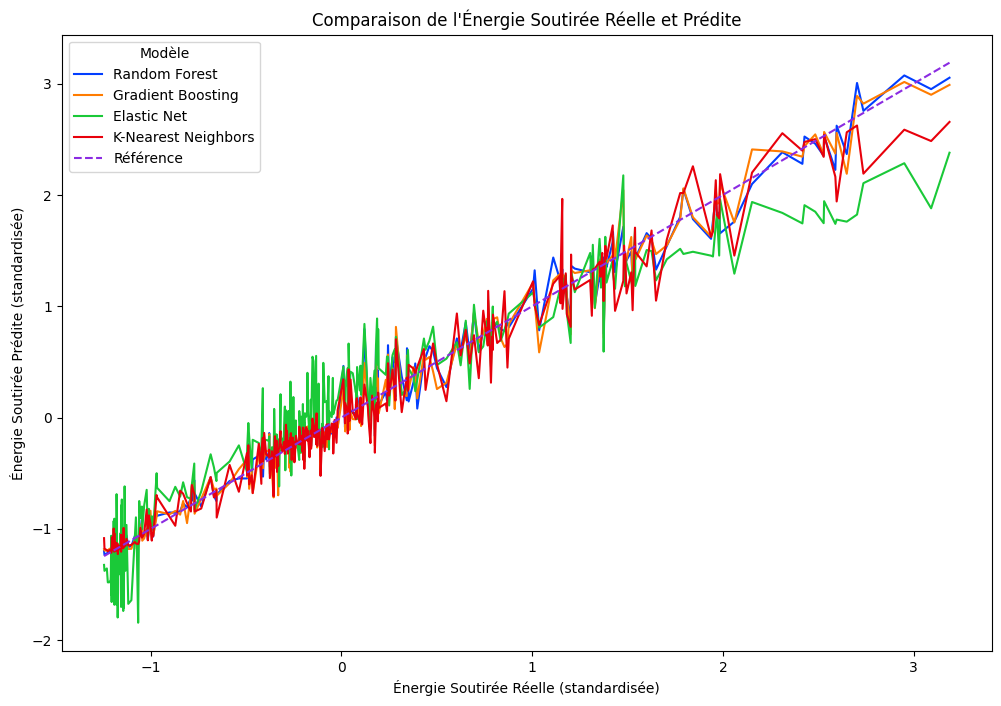

In [ ]:
plot_predictions(y_test, X_test, model)

Random Forest - **MSE**: 0.01628844214204153, **R2 Train**: 0.9969449930393479, **R2 Test**: 0.9839135030089

Gradient Boosting - **MSE**: 0.01686830472714337,** R2 Train**: 0.9901796578861448, **R2 Test**: 0.9833408295973393

Elastic Net - **MSE**: 0.7115840253994932, **R2 Train**: 0.29538161220505743, **R2 Test**: 0.29723823901129276

K-Nearest Neighbors -**MSE**: 0.030096566504019456, **R2 Train**: 0.9726196338415452, **R2 Test**: 0.970276572658859

### Conclusion Les résultats des modèles montrent que :

**Random Forest :**

MSE : 0.0164, indiquant une très faible erreur moyenne quadratique.
R2 Train : 0.9970, suggérant un excellent ajustement aux données d'entraînement.
R2 Test : 0.9838, montrant une excellente capacité de généralisation aux données de test.

**Gradient Boosting :**

MSE : 0.0168, également très faible et proche de Random Forest.
R2 Train : 0.9902, indiquant une très bonne performance sur les données d'entraînement.
R2 Test : 0.9834, presque aussi bon que Random Forest, ce qui montre une très bonne généralisation.

**K-Nearest Neighbors (KNN) :**

MSE : 0.0301, un peu plus élevé, mais reste faible.
R2 Train : 0.9726, ce qui est bon, mais légèrement inférieur aux deux premiers modèles.
R2 Test : 0.9703, indiquant une bonne performance, bien que légèrement inférieure à Random Forest et Gradient Boosting.

**Elastic Net :**
Avec les paramètres par défaut:
MSE : 0.7116, ce qui est nettement supérieur, indiquant une performance médiocre.
R2 Train : 0.2954, montrant une faible capacité d'ajustement aux données d'entraînement.
R2 Test : 0.2972, reflétant une mauvaise généralisation aux données de test.

Après optimisation (gridSearchCV):
Les scores R2 sont améliorés R2 Train: 0.91304, R2 Test: 0.90566. Mais c'est encore loin des performances des autres modèles

## **Conclusion :**
Les modèles Random Forest et Gradient Boosting sont les plus performants, offrant des prédictions précises avec un faible MSE et un R² élevé. Ils démontrent une excellente capacité à généraliser aux nouvelles données. Le K-Nearest Neighbors présente également de bonnes performances, mais est légèrement inférieur aux deux premiers modèles. En revanche, l'Elastic Net ne semble pas bien adapté aux données, offrant des résultats nettement moins précis avec une erreur plus élevée et un R² plus faible.

## Test 2 sans Nb de points de soutirage

In [ ]:
# Liste des colonnes pertinentes pour les caractéristiques (X) sans 'Nb points soutirage'
cols_features = [
    'Jour', 'Mois', 'REGION_Centre-Val de Loire', 'REGION_Hauts-de-France', 'Vacances',
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH', 'PRECIP_TOTAL_DAY_MM',
    'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM', 'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT',
    'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'Day Length'
]

# Sélection des caractéristiques (X) et de la cible (y) - Total énergie soutirée (Wh)
X = df_encoded[cols_features]
y = df_encoded['ENERGIE_SOUTIREE']

# Standardisation des données
scaler_X = StandardScaler()
# Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)
X_scaled = scaler_X.fit_transform(X_imputed)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Division des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    # 'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    results[name] = {'MSE': mse, 'R2 Train': train_accuracy, 'R2 Test': test_accuracy}

# Affichage des résultats
for name, metrics in results.items():
  print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")

Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 0.01919656959552499 *R2 Train: 0.9969899346220742 *R2 Test: 0.9810414307062056
*Gradient Boosting  *MSE: 0.017551451436826727 *R2 Train: 0.9889874230602695 *R2 Test: 0.9826661525844016
*Elastic Net  *MSE: 0.09540766921546442 *R2 Train: 0.9131317945830134 *R2 Test: 0.905775201189985
*K-Nearest Neighbors  *MSE: 0.03931586389028097 *R2 Train: 0.9714605634696051 *R2 Test: 0.9611715767132146


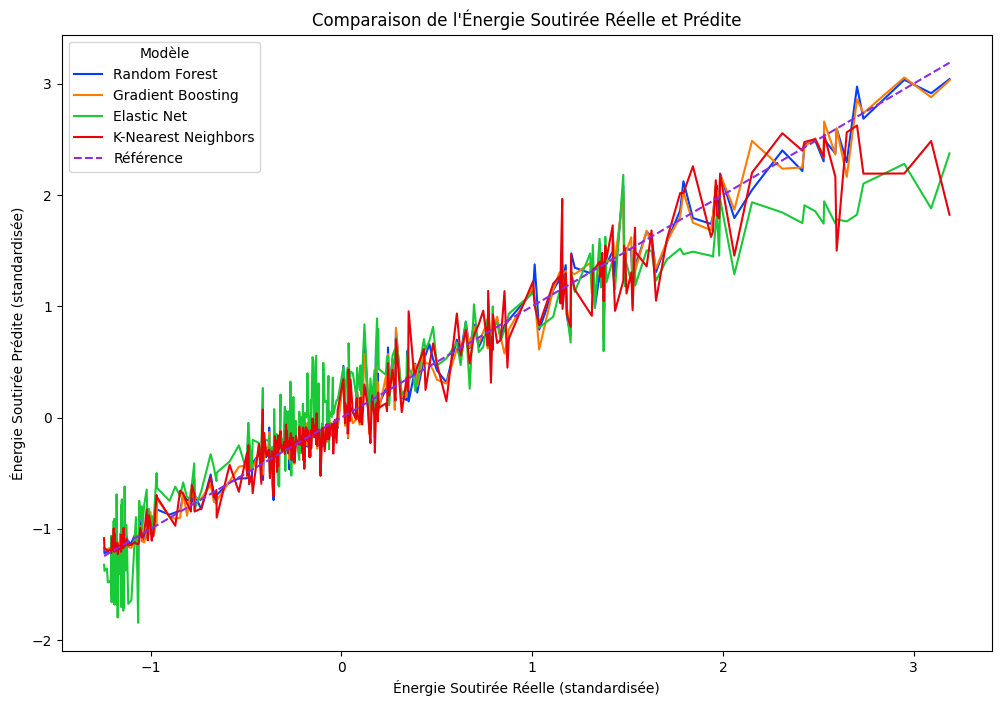

In [ ]:
# Faire des prédictions avec chaque modèle sur l'ensemble de test
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

# Créer un DataFrame pour visualiser les prédictions et la cible réelle
df_viz = pd.DataFrame({
    'ENERGIE_SOUTIREE_REELLE': y_test,  # Données réelles (échelle standardisée)
    'Random Forest': predictions['Random Forest'],
    'Gradient Boosting': predictions['Gradient Boosting'],
    'Elastic Net': predictions['Elastic Net'],
    'K-Nearest Neighbors': predictions['K-Nearest Neighbors']
})

# Visualisation des prédictions versus les valeurs réelles de l'énergie soutirée
sns.set_palette("bright")
plt.figure(figsize=(12, 8))

# Ajout des courbes de prédictions des différents modèles
sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Random Forest', data=df_viz, label='Random Forest')
sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Gradient Boosting', data=df_viz, label='Gradient Boosting')
sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='Elastic Net', data=df_viz, label='Elastic Net')
sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='K-Nearest Neighbors', data=df_viz, label='K-Nearest Neighbors')

# Ajout de la ligne de référence des valeurs réelles
sns.lineplot(x='ENERGIE_SOUTIREE_REELLE', y='ENERGIE_SOUTIREE_REELLE', data=df_viz, label='Référence', linestyle='--')

# Personnalisation de l'affichage
plt.title('Comparaison de l\'Énergie Soutirée Réelle et Prédite')
plt.xlabel('Énergie Soutirée Réelle (standardisée)')
plt.ylabel('Énergie Soutirée Prédite (standardisée)')
plt.legend(title='Modèle')
plt.show()


Random Forest - **MSE**: 0.018333245316699484, **R2 Train**: 0.997068522400763, **R2 Test**: 0.9818940514352209

Gradient Boosting - **MSE**: 0.017529769119324735, **R2 Train**: 0.9889874230602695, **R2 Test**: 0.9826875660831398

Elastic Net - **MSE**: 0.09540766921546442, **R2 Train**: 0.9131317945830134, **R2 Test**: 0.905775201189985

K-Nearest Neighbors - **MSE**: 0.03931586389028097, **R2 Train**: 0.9714605634696051, **R2 Test**: 0.9611715767132146

Les résultats des modèles sont les suivants :

**Random Forest :**

MSE : 0.0183, indiquant une faible erreur moyenne quadratique.
R2 Train : 0.9971, suggérant un excellent ajustement aux données d'entraînement.
R2 Test : 0.9819, montrant une excellente capacité de généralisation aux données de test.

**Gradient Boosting :**

MSE : 0.0175, légèrement inférieur à Random Forest, indiquant une très faible erreur.
R2 Train : 0.9890, démontrant une très bonne performance sur les données d'entraînement.
R2 Test : 0.9827, légèrement supérieur à Random Forest, ce qui montre une très bonne généralisation.

**K-Nearest Neighbors (KNN) :**

MSE : 0.0393, plus élevé, mais reste dans des limites acceptables.
R2 Train : 0.9715, ce qui est bon, bien que légèrement inférieur aux deux premiers modèles.
R2 Test : 0.9612, indiquant une bonne performance, mais inférieure à Random Forest et Gradient Boosting.

**Elastic Net :**

MSE : 0.7202, nettement plus élevé, ce qui indique une performance médiocre.
R2 Train : 0.2865, montrant une faible capacité d'ajustement aux données d'entraînement.
R2 Test : 0.2887, reflétant une mauvaise généralisation aux données de test.
Après optimisation (gridSearchCV):
Les scores R2 sont améliorés grandemment améliorés. Mais c'est encore loin des performances des autres modèles

**Conclusion :**
Les modèles Random Forest et Gradient Boosting sont les plus performants, offrant des prédictions précises avec un faible MSE et un R² élevé. Le Gradient Boosting a un léger avantage sur le Random Forest en termes de généralisation sur les données de test. Le K-Nearest Neighbors présente également de bonnes performances, bien que légèrement inférieures aux deux premiers modèles. L'Elastic Net, en revanche, ne semble pas bien adapté aux données, offrant des résultats nettement moins précis avec une erreur plus élevée et un R² plus faible.








## Test 3 X minimaliste

Variables obligatoires d'après l'énoncé: température et précipitations

In [ ]:
# Liste des colonnes pertinentes pour les caractéristiques (X)
cols_features = [
    #'NB_POINTS_SOUTIRAGE',
    'Jour', 'Mois',
    'REGION_Centre-Val de Loire','REGION_Hauts-de-France',
    'Vacances',
    #'MAX_TEMPERATURE_C', # A voir si on ajoute ou pas...
    'MIN_TEMPERATURE_C',
    #'WINDSPEED_MAX_KMH',
    'PRECIP_TOTAL_DAY_MM',
    #'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
    #'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C',
    #'WINDTEMP_MAX_C',
    'Day Length'
]

# Sélection des caractéristiques (X) et de la cible (y) - Total énergie soutirée (Wh)
X = df_encoded[cols_features]
y = df_encoded['ENERGIE_SOUTIREE']

# Standardisation des données
scaler_X = StandardScaler()
# Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)
X_scaled = scaler_X.fit_transform(X_imputed)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Division des données en entraînement et test
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))

    results[name] = {'MSE': mse, 'R2 Train': r2_train, 'R2 Test': r2_test,'Score Train': r2_train, 'Score Test': r2_test}

# Affichage des résultats
for name, metrics in results.items():
    print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")


Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 3.724099391871342e+18 *R2 Train: 0.99717747146597 *R2 Test: 0.9815274686413468
*Gradient Boosting  *MSE: 4.244974317476812e+18 *R2 Train: 0.9845978713295637 *R2 Test: 0.9789437893716191
*Elastic Net  *MSE: 1.941206769305784e+19 *R2 Train: 0.9088607045161498 *R2 Test: 0.9037109401593814
*K-Nearest Neighbors  *MSE: 6.447458783938804e+18 *R2 Train: 0.9782430360832237 *R2 Test: 0.968018875965046


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e+22, tolerance: 2.896e+19
  model = cd_fast.enet_coordinate_descent(


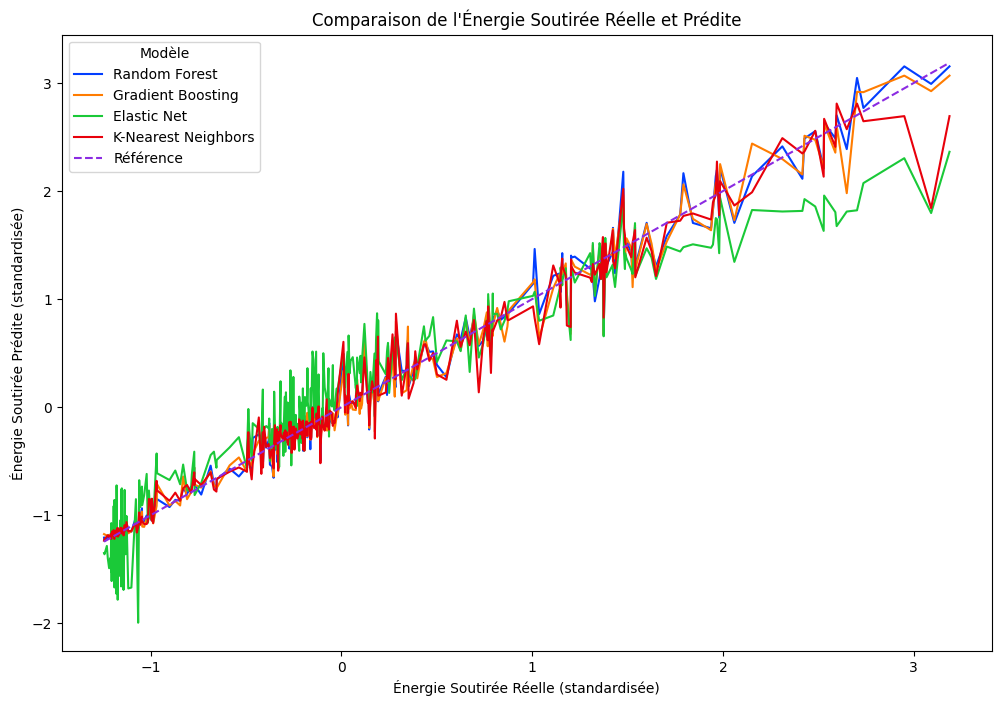

In [ ]:

plot_predictions(y_test, X_test, model)


## Test 4A avec PCA (avec X minimaliste dernière version)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Liste des colonnes pertinentes pour les caractéristiques (X) sans 'Nb points soutirage'

cols_features = [
    #'NB_POINTS_SOUTIRAGE',
    'Jour', 'Mois',
    'REGION_Centre-Val de Loire','REGION_Hauts-de-France',
    'Vacances',
    #'MAX_TEMPERATURE_C',
    'MIN_TEMPERATURE_C',
    #'WINDSPEED_MAX_KMH',
    'PRECIP_TOTAL_DAY_MM',
    #'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
    #'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C',
    #'WINDTEMP_MAX_C',
    'Day Length'
]

# Sélection des caractéristiques (X) et de la cible (y) - Total énergie soutirée (Wh)
X = df_encoded[cols_features]
y = df_encoded['ENERGIE_SOUTIREE']

In [ ]:
# Création d'un imputer avec 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)

In [ ]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Réduction dimension avec PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Scatterplot PCA
import plotly.express as px
df_encoded['PCA1'] = X_pca[:, 0]
df_encoded['PCA2'] = X_pca[:, 1]

fig = px.scatter(df_encoded, x='PCA1', y='PCA2', color='ENERGIE_SOUTIREE',
                 labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'})
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Séparation du dataset en 4 populations
X_trainPCA, X_testPCA, y_train, y_test = train_test_split(X_pca, y, random_state = 55)

In [ ]:
# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")

    #Modif PCA
    # model.fit(X_train, y_train)
    model.fit(X_trainPCA, y_train)

    y_pred = model.predict(X_testPCA)
    mse = mean_squared_error(y_test, y_pred)
    train_score = model.score(X_trainPCA, y_train)
    test_score = model.score(X_testPCA, y_test)
    r2_train = r2_score(y_train, model.predict(X_trainPCA))
    r2_test = r2_score(y_test, model.predict(X_testPCA))

    results[name] = {'MSE': mse, 'R2 Train': r2_train, 'R2 Test': r2_test,'Score Train': r2_train, 'Score Test': r2_test}

# Affichage des résultats
for name, metrics in results.items():
    print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")


Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 5.462821838995176e+18 *R2 Train: 0.9960846226476149 *R2 Test: 0.9691253638145204
*Gradient Boosting  *MSE: 5.829500701389032e+18 *R2 Train: 0.9848155121795558 *R2 Test: 0.9670529776362814
*Elastic Net  *MSE: 1.6013344842773692e+19 *R2 Train: 0.9072731161509378 *R2 Test: 0.9094961888370491
*K-Nearest Neighbors  *MSE: 7.136057826533214e+18 *R2 Train: 0.9794513509342144 *R2 Test: 0.9596686116285126


**Conclusion**: Les scores obtenus sont plus faibles (0.97 pour RandomForest) par rapport au test 3 (0.98 pour RandomForest)... donc pas intéressant d'appliquer la réduction PCA avant le modèle.

## Test 4B avec PCA (avec X full 12 variables méteo)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Liste des colonnes pertinentes pour les caractéristiques (X) sans 'Nb points soutirage'

cols_features = [
    #'NB_POINTS_SOUTIRAGE',
    'Jour', 'Mois',
    'REGION_Centre-Val de Loire','REGION_Hauts-de-France',
    'Vacances',
    'MAX_TEMPERATURE_C',
    'MIN_TEMPERATURE_C',
    'WINDSPEED_MAX_KMH',
    'PRECIP_TOTAL_DAY_MM',
    'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
    'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C',
    'WINDTEMP_MAX_C',
    'Day Length'
]

# Sélection des caractéristiques (X) et de la cible (y) - Total énergie soutirée (Wh)
X = df_encoded[cols_features]
y = df_encoded['ENERGIE_SOUTIREE']

In [ ]:
# Création d'un imputer avec 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)

In [ ]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Réduction dimension avec PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Scatterplot PCA
import plotly.express as px
df_encoded['PCA1'] = X_pca[:, 0]
df_encoded['PCA2'] = X_pca[:, 1]

fig = px.scatter(df_encoded, x='PCA1', y='PCA2', color='ENERGIE_SOUTIREE',
                 labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'})
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Séparation du dataset en 4 populations
X_trainPCA, X_testPCA, y_train, y_test = train_test_split(X_pca, y, random_state = 55)

In [ ]:
# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")

    #Modif PCA
    # model.fit(X_train, y_train)
    model.fit(X_trainPCA, y_train)

    y_pred = model.predict(X_testPCA)
    mse = mean_squared_error(y_test, y_pred)
    train_score = model.score(X_trainPCA, y_train)
    test_score = model.score(X_testPCA, y_test)
    r2_train = r2_score(y_train, model.predict(X_trainPCA))
    r2_test = r2_score(y_test, model.predict(X_testPCA))

    results[name] = {'MSE': mse, 'R2 Train': r2_train, 'R2 Test': r2_test,'Score Train': r2_train, 'Score Test': r2_test}

# Affichage des résultats
for name, metrics in results.items():
    print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")


Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 5.81599223614875e+18 *R2 Train: 0.9945688444733519 *R2 Test: 0.9671293244332317
*Gradient Boosting  *MSE: 5.230394902923978e+18 *R2 Train: 0.9869498431986183 *R2 Test: 0.9704389884031311
*Elastic Net  *MSE: 1.5139790963018721e+19 *R2 Train: 0.910816161565727 *R2 Test: 0.9144333182219623
*K-Nearest Neighbors  *MSE: 8.11636020160872e+18 *R2 Train: 0.9726641779020814 *R2 Test: 0.9541281638390264


**Conclusion**: Les scores obtenus sont plus faibles (0.97 pour RandomForest) par rapport au test 3 (0.98 pour RandomForest)... donc pas intéressant d'appliquer la réduction PCA avant le modèle.

## Construction du dataframe V1 -
pour le modèle ML et ecriture dans un csv

Il faut avoir exécuter le chargement du dataframe

### Pré-Traitements du DF
Modifications à faire si on récupere le csv merge du drive rep/donnees/Conso+Meteo+Vacances

In [ ]:
#df_conso_meteo= pd.read_csv("/content/drive/MyDrive/df_hf_cvl_full.csv", sep = ',')
df_conso_meteo= pd.read_csv("https://drive.google.com/uc?export=view&id=1-MESKGsp48qZbEYwMeb4mKxHSo39F82T", sep = ',')
# Convertir la colonne 'Date' en type datetime
df_conso_meteo['DATE'] = pd.to_datetime(df_conso_meteo['DATE'])

# Extraire le jour et le mois
df_conso_meteo['Jour'] = df_conso_meteo['DATE'].dt.day
df_conso_meteo['Mois'] = df_conso_meteo['DATE'].dt.month

# Supprimer la colonne 'Date' car pas utile
df_conso_meteo.drop(columns=['Date'], inplace=True)

# # Conversion des colonnes SUNSET et SUNRISE en format datetime
df_conso_meteo['SUNRISE'] = pd.to_datetime(df_conso_meteo['SUNRISE'], format='%H:%M:%S')
df_conso_meteo['SUNSET'] = pd.to_datetime(df_conso_meteo['SUNSET'], format='%H:%M:%S')

# Calcul de la longueur du jour
df_conso_meteo['Day Length'] = (df_conso_meteo['SUNSET'] - df_conso_meteo['SUNRISE']).dt.total_seconds() / 3600  # En heures

# Application du One-Hot Encoding à la colonne OPINION
df_encoded = pd.get_dummies(df_conso_meteo, columns=['OPINION'])

# One-Hot Encoding pour la colonne 'Région'
df_encoded = pd.get_dummies(df_encoded, columns=['REGION'])

cols_features = [
    'Jour', 'Mois',
    'REGION_Centre-Val de Loire','REGION_Hauts-de-France',
    'Vacances',
    #'MAX_TEMPERATURE_C', # A voir si on ajoute ou pas...
    'MIN_TEMPERATURE_C',
    'PRECIP_TOTAL_DAY_MM',
    'Day Length',
    'ENERGIE_SOUTIREE'
]
df_encoded = df_encoded[cols_features]

df_encoded.head()


,Jour,Mois,REGION_Centre-Val de Loire,REGION_Hauts-de-France,Vacances,MIN_TEMPERATURE_C,PRECIP_TOTAL_DAY_MM,Day Length,ENERGIE_SOUTIREE
0,1,1,True,False,0,8.0,0.0,8.566667,2.729271e+10
1,2,1,True,False,0,9.0,0.0,8.583333,2.793946e+10
2,3,1,True,False,0,10.0,1.0,8.600000,2.820313e+10
3,4,1,True,False,0,4.0,5.0,8.616667,2.926651e+10
4,5,1,True,False,0,1.0,2.0,8.633333,3.375534e+10


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Jour                        1824 non-null   int32  
 1   Mois                        1824 non-null   int32  
 2   REGION_Centre-Val de Loire  1824 non-null   bool   
 3   REGION_Hauts-de-France      1824 non-null   bool   
 4   Vacances                    1824 non-null   int64  
 5   MIN_TEMPERATURE_C           1824 non-null   float64
 6   PRECIP_TOTAL_DAY_MM         1824 non-null   float64
 7   Day Length                  1824 non-null   float64
dtypes: bool(2), float64(3), int32(2), int64(1)
memory usage: 74.9 KB


In [ ]:
#ecrire le df dans un csv
df_encoded.to_csv('df_ML_RF_minimalist.csv', index=False)

!cp df_ML_RF_minimalist.csv "drive/My Drive/"

# Partie II - TEST unitaire Prediction

### Fonction pour récupérer les vacances

In [ ]:
pip install vacances-scolaires-france

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.8 MB/s eta 0:00:00


In [ ]:
from vacances_scolaires_france import SchoolHolidayDates
from datetime import datetime

def vacances(date,region):

  # définir le dico avec la liste des régions par zone: https://www.vacances-scolaires-education.fr/regions-zones-vacances-scolaires.html
  zone_A = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Nouvelle Aquitaine']
  zone_B =  [ 'Bretagne','Centre-Val de Loire', 'Grand-Est', 'Hauts-de-France',
              'Normandie','Nouvelle Aquitaine', 'Pays de la Loire',"Provence-Alpes-Côte d'Azur"]
  zone_C = ['Occitanie' 'Île-de-France']

  #récuperer la zone de la région
  if region in zone_A:
    zone = 'A'
  elif region in zone_B:
    zone = 'B'
  elif region in zone_C:
    zone = 'C'

  #récupérer les vacances pour la zone et la date
  d = SchoolHolidayDates()
  is_vacances = d.is_holiday_for_zone(date.date(), zone)

  return is_vacances

## Lecture du DF  à partir du csv dans le drive

In [ ]:

# all regions dfmlenedis https://drive.google.com/file/d/18fvtQ6eODZiWdfv-Rik6LOXzJECDl_Ay/view?usp=drive_link
df_ML= pd.read_csv("https://drive.google.com/uc?export=view&id=18fvtQ6eODZiWdfv-Rik6LOXzJECDl_Ay", sep = ',')
df_ML.head()

,DATE,REGION,NB_POINTS_SOUTIRAGE,ENERGIE_SOUTIREE,Avg_Temperature,Avg_Précipitations_24h,DayLength_hours,Vacances,day,month,year
0,2022-01-01,Auvergne-Rhône-Alpes,231089068,8.296446e+10,6.859375,0.012500,8.798954,1,1,1,2022
1,2022-01-01,Bourgogne-Franche-Comté,82167622,2.837146e+10,3.975000,0.087500,8.547970,1,1,1,2022
2,2022-01-01,Bretagne,103421842,3.640157e+10,13.018750,0.717857,8.426364,1,1,1,2022
3,2022-01-01,Centre-Val de Loire,68742328,2.729271e+10,8.537500,0.000000,8.550140,1,1,1,2022
4,2022-01-01,Grand-Est,145625744,4.850288e+10,8.138462,0.040000,8.384981,1,1,1,2022


In [ ]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE                    10944 non-null  object 
 1   REGION                  10944 non-null  object 
 2   NB_POINTS_SOUTIRAGE     10944 non-null  int64  
 3   ENERGIE_SOUTIREE        10944 non-null  float64
 4   Avg_Temperature         10944 non-null  float64
 5   Avg_Précipitations_24h  10944 non-null  float64
 6   DayLength_hours         10944 non-null  float64
 7   Vacances                10944 non-null  int64  
 8   day                     10944 non-null  int64  
 9   month                   10944 non-null  int64  
 10  year                    10944 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 940.6+ KB


In [ ]:
df_ML.columns

Index(['DATE', 'REGION', 'NB_POINTS_SOUTIRAGE', 'ENERGIE_SOUTIREE',
       'Avg_Temperature', 'Avg_Précipitations_24h', 'DayLength_hours',
       'Vacances', 'day', 'month', 'year'],
      dtype='object')

##Test minimaliste avec toutes les régions

Variables obligatoires d'après l'énoncé: température et précipitations

In [ ]:
# Liste des colonnes pertinentes pour les caractéristiques (X)
y = df_ML['ENERGIE_SOUTIREE']
#définir le X à partir des noms de colonne
colonnes = [
            'NB_POINTS_SOUTIRAGE',
            'Avg_Temperature', 'Avg_Précipitations_24h',
            'DayLength_hours', 'Vacances', 'day', 'month',
            # 'REGION_Auvergne-Rhône-Alpes', 'REGION_Bourgogne-Franche-Comté',
            # 'REGION_Bretagne', 'REGION_Centre-Val de Loire', 'REGION_Grand-Est',
            # 'REGION_Hauts-de-France', 'REGION_Normandie',
            # 'REGION_Nouvelle Aquitaine', 'REGION_Occitanie',
            # 'REGION_Pays de la Loire', "REGION_Provence-Alpes-Côte d'Azur",
            # 'REGION_Île-de-France'
            ]
X = df_ML.loc[:,colonnes]

# Standardisation des données
scaler_X = StandardScaler()
# Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)
X_scaled = scaler_X.fit_transform(X_imputed)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Division des données en entraînement et test
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Préparation des modèles
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.23),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Espace réservé pour les résultats
results = {}

# Entraînement des modèles et évaluation
for name, model in models.items():
    print(f"Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))

    results[name] = {'MSE': mse, 'R2 Train': r2_train, 'R2 Test': r2_test,'Score Train': r2_train, 'Score Test': r2_test}

# Affichage des résultats
for name, metrics in results.items():
    print(f"*{name}  *MSE: {metrics['MSE']} *R2 Train: {metrics['R2 Train']} *R2 Test: {metrics['R2 Test']}")


Entraînement de Random Forest...
Entraînement de Gradient Boosting...
Entraînement de Elastic Net...
Entraînement de K-Nearest Neighbors...
*Random Forest  *MSE: 7.516798259443312e+18 *R2 Train: 0.9981720778987893 *R2 Test: 0.9847385754562483
*Gradient Boosting  *MSE: 9.775407603800121e+18 *R2 Train: 0.9819610330204962 *R2 Test: 0.9801529001603323
*Elastic Net  *MSE: 6.76513859701543e+19 *R2 Train: 0.862687019990757 *R2 Test: 0.862646769724509
*K-Nearest Neighbors  *MSE: 1.5264983792895943e+19 *R2 Train: 0.9795613353662946 *R2 Test: 0.9690073632049124


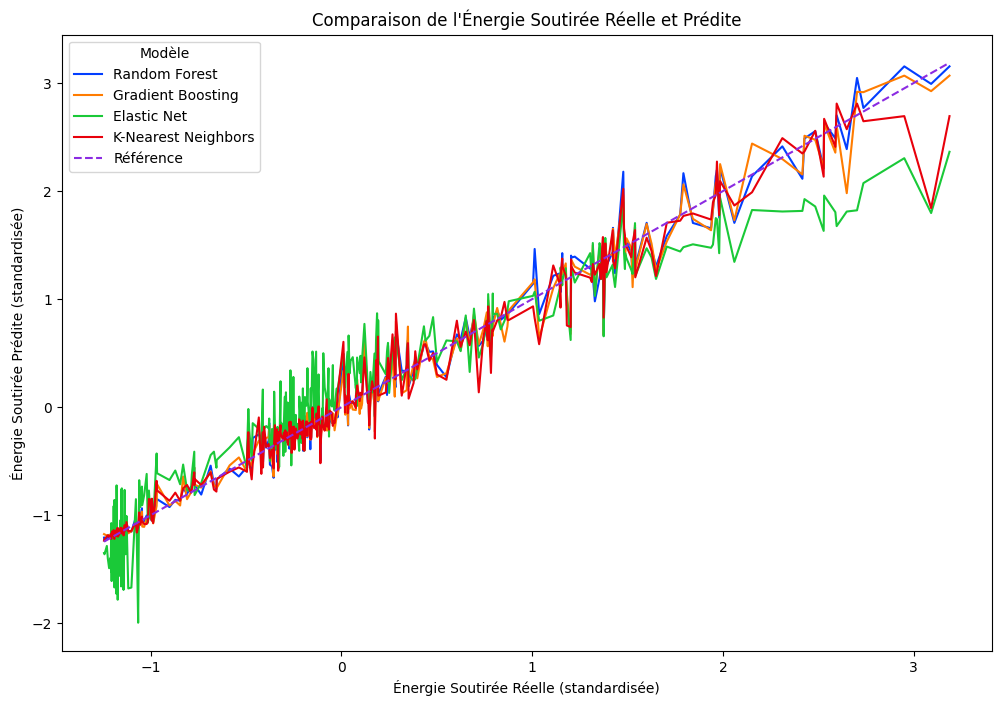

In [ ]:

plot_predictions(y_test, X_test, model)


## Encoding de la région


In [ ]:
def encode_region(df):
    # One-Hot Encoding pour la colonne 'Région'
    df_encoded = pd.get_dummies(df, columns=['REGION'])

    list_of_regions = ['REGION_Auvergne-Rhône-Alpes', 'REGION_Bourgogne-Franche-Comté',
                      'REGION_Bretagne', 'REGION_Centre-Val de Loire', 'REGION_Grand-Est',
                      'REGION_Hauts-de-France', 'REGION_Normandie',
                      'REGION_Nouvelle Aquitaine', 'REGION_Occitanie',
                      'REGION_Pays de la Loire', "REGION_Provence-Alpes-Côte d'Azur",
                      'REGION_Île-de-France']
    for col in list_of_regions:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    # #mettre à 1 la colonne de la region
    # nom_colonne = 'REGION_'+ region
    # df_encoded[nom_colonne] = 1
    return df_encoded

##Optimisation

In [ ]:
y = df_ML['ENERGIE_SOUTIREE']
#définir le X à partir des noms de colonne
colonnes = [
            'NB_POINTS_SOUTIRAGE',
            'Avg_Temperature', 'Avg_Précipitations_24h',
            'DayLength_hours', 'Vacances', 'day', 'month',
            ]
X = df_ML.loc[:,colonnes]

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
#Meilleurs paramètres pour Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}

In [ ]:
# Standardisation des données
scaler_X = StandardScaler()

# Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')

# Appliquer l'imputer sur X avant la standardisation
X_imputed = imputer.fit_transform(X)
X_scaled = scaler_X.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
print("Meilleurs paramètres pour Random Forest:", grid_search_rf.best_params_)

Meilleurs paramètres pour Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


Note : Seul l'hyper-paramètre 'max_depth': 30 est différent de la valeur par défaut avant optim (par défaut max_depth=None )

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
# chemin='/content/drive/MyDrive/dfmlenedis.csv'
# df.to_csv(chemin, index=False)

##Fonction init() du modèle RandomForestRegressor()

In [ ]:
def init_model(X,y):

  # Standardisation des données
  scaler_X = StandardScaler()

  # Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
  imputer = SimpleImputer(strategy='mean')

  # Appliquer l'imputer sur X avant la standardisation
  X_imputed = imputer.fit_transform(X)
  X_scaled = scaler_X.fit_transform(X_imputed)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  #creation du modele Random Forest {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
  model = RandomForestRegressor(max_depth= 30, min_samples_split= 2, n_estimators=100)
  #creation avec les params du meilleur modèle

  #entrainement
  model.fit(X_train, y_train)

  #evaluation
  score_train = model.score(X_train, y_train)
  score_test = model.score(X_test, y_test)
  y_pred = model.predict(X_test)
  print(f" Avec max_depth= 30 *MSE: {mean_squared_error(y_test, y_pred)} *R2 Train: {score_train} *R2 Test: {score_test}")
  return model,scaler_X,score_train,score_test



## Cross validation
(non nécessaire car déjà fait dans GridSearchCV(), mais pour le fun ;p

In [ ]:
from sklearn.model_selection import cross_val_score
#la meme focntion mais incluant une crossvalidation
def init_model_CV(X,y):

  # Standardisation des données
  scaler_X = StandardScaler()

  # Créer un objet SimpleImputer avec la stratégie 'mean' pour remplacer les NaN par la moyenne de la colonne
  imputer = SimpleImputer(strategy='mean')

  # Appliquer l'imputer sur X avant la standardisation
  X_imputed = imputer.fit_transform(X)
  X_scaled = scaler_X.fit_transform(X_imputed)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  #creation du modele Random Forest {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
  model = RandomForestRegressor(max_depth= 30, min_samples_split= 2, n_estimators=100)
  #creation avec les params du meilleur modèle

  #entrainement
  model.fit(X_train, y_train)

  #evaluation
  score_train = model.score(X_train, y_train)
  score_test = model.score(X_test, y_test)
  #crossvalidation sur l'ensemble de train

  scores = cross_val_score(model, X_train, y_train, cv=5)
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

  return model,scaler_X,score_train,score_test

##Fonction Prediction

In [ ]:
def predict(model,X_scaler,date, region, temperature,precipitation):
  ## Variables Calculées # ###

  #verifier si c'est les vacances ce jour là
  Vacances = vacances(date,region)

  #Calculer la mediane de Day_Length, Avg_Temperature et Avg_Précipitations_24h pour le  jour et mois, les années passées
  mask = (df_ML['month'] == date.month) & (df_ML['day'] == date.day)
  DayLength_hours =  df_ML.loc[mask, 'DayLength_hours'].median()
  mask_region = (df_ML['REGION'] == region)
  nb_points_soutirage = df_ML.loc[mask_region, 'NB_POINTS_SOUTIRAGE'].median()
  print("Date : ",date)
  print(f"Vacances : ", Vacances )
  print(f"Avg_Temperature : ", temperature )
  print(f"Avg_Précipitations_24h : ", precipitation )
  print(f"DayLength_hours : ", DayLength_hours )
  # Contenu d'une observation X :

  X_input = pd.DataFrame([[
                          nb_points_soutirage,
                          temperature, precipitation,
                          DayLength_hours,Vacances, date.day,date.month]],
                          columns=['NB_POINTS_SOUTIRAGE', 'Avg_Temperature', 'Avg_Précipitations_24h',
                                   'DayLength_hours', 'Vacances', 'day', 'month'])

  # #on encode la colonne region avec toutes le valeurs possibles de Région

  # X_input = encode_region(X_input)
  # display("X_input :", X_input)

  #scaling de la nouvelle observation
  X_scaled = X_scaler.transform(X_input)
  # X_scaled = X_input

  #on fait la prediction de conso electrique
  prediction = model.predict(X_scaled)

  return prediction

## Test

In [ ]:
# On lit le df
df_ML= pd.read_csv("https://drive.google.com/uc?export=view&id=18fvtQ6eODZiWdfv-Rik6LOXzJECDl_Ay", sep = ',')
df_ML.head()
#on encode la colonne région
# df_ML = encode_region(df_ML)
df_ML.head()

,DATE,REGION,NB_POINTS_SOUTIRAGE,ENERGIE_SOUTIREE,Avg_Temperature,Avg_Précipitations_24h,DayLength_hours,Vacances,day,month,year
0,2022-01-01,Auvergne-Rhône-Alpes,231089068,8.296446e+10,6.859375,0.012500,8.798954,1,1,1,2022
1,2022-01-01,Bourgogne-Franche-Comté,82167622,2.837146e+10,3.975000,0.087500,8.547970,1,1,1,2022
2,2022-01-01,Bretagne,103421842,3.640157e+10,13.018750,0.717857,8.426364,1,1,1,2022
3,2022-01-01,Centre-Val de Loire,68742328,2.729271e+10,8.537500,0.000000,8.550140,1,1,1,2022
4,2022-01-01,Grand-Est,145625744,4.850288e+10,8.138462,0.040000,8.384981,1,1,1,2022


###Avec le meilleur estimateur

In [ ]:
y = df_ML['ENERGIE_SOUTIREE']
#définir le X à partir des noms de colonne
colonnes = [
            'NB_POINTS_SOUTIRAGE',
            'Avg_Temperature', 'Avg_Précipitations_24h',
            'DayLength_hours', 'Vacances', 'day', 'month',
            # 'REGION_Auvergne-Rhône-Alpes', 'REGION_Bourgogne-Franche-Comté',
            # 'REGION_Bretagne', 'REGION_Centre-Val de Loire', 'REGION_Grand-Est',
            # 'REGION_Hauts-de-France', 'REGION_Normandie',
            # 'REGION_Nouvelle Aquitaine', 'REGION_Occitanie',
            # 'REGION_Pays de la Loire', "REGION_Provence-Alpes-Côte d'Azur",
            # 'REGION_Île-de-France'
            ]
X = df_ML.loc[:,colonnes]

#initialiser le modèle avec la fonction init_model(X,y)  définie avant et qui inclut le split train/test
model,scaler,train_score,test_score = init_model_CV(X,y)
print('score train : ',train_score)
print('score test : ',test_score)
print(X.columns)

0.99 accuracy with a standard deviation of 0.00
score train :  0.9982036423491382
score test :  0.9851582879395504
Index(['NB_POINTS_SOUTIRAGE', 'Avg_Temperature', 'Avg_Précipitations_24h',
       'DayLength_hours', 'Vacances', 'day', 'month'],
      dtype='object')


###Test initial avant optim

In [ ]:
# Le df est déjà récupéré, on défini les features
# X = df_ML.drop(columns=['ENERGIE_SOUTIREE','year','DATE'])
y = df_ML['ENERGIE_SOUTIREE']
#définir le X à partir des noms de colonne
colonnes = [
            'NB_POINTS_SOUTIRAGE',
            'Avg_Temperature', 'Avg_Précipitations_24h',
            'DayLength_hours', 'Vacances', 'day', 'month',
            # 'REGION_Auvergne-Rhône-Alpes', 'REGION_Bourgogne-Franche-Comté',
            # 'REGION_Bretagne', 'REGION_Centre-Val de Loire', 'REGION_Grand-Est',
            # 'REGION_Hauts-de-France', 'REGION_Normandie',
            # 'REGION_Nouvelle Aquitaine', 'REGION_Occitanie',
            # 'REGION_Pays de la Loire', "REGION_Provence-Alpes-Côte d'Azur",
            # 'REGION_Île-de-France'
            ]
X = df_ML.loc[:,colonnes]

#initialiser le modèle avec la fonction init_model(X,y)  définie avant et qui inclut le split train/test
model,scaler,train_score,test_score = init_model(X,y)
print('score train : ',train_score)
print('score test : ',test_score)
print(X.columns)

 Avec max_depth= 30 *MSE: 7.346822185548377e+18 *R2 Train: 0.9981482319867694 *R2 Test: 0.9850836794402128
score train :  0.9981482319867694
score test :  0.9850836794402128
Index(['NB_POINTS_SOUTIRAGE', 'Avg_Temperature', 'Avg_Précipitations_24h',
       'DayLength_hours', 'Vacances', 'day', 'month'],
      dtype='object')


In [ ]:
### TEST 1 ##
#Test 1
# à Bourges 2021-03-01 (MAX_TEMPERATURE_C)	MIN_TEMPERATURE_C	PRECIP_TOTAL_DAY_MM SUNHOUR
#2021-03-01	(15)	MIN_TEMP: 3		PRECIP0 --SUNHOURS 11.1

## Variables entrées par l'utilisateur  # ###
Region =  'Centre-Val de Loire'
Jour = 1
# on essaye Une année non vue par le modèle pour tester ?
Annee = 2021
#Test 1
# à Bourges 2021-03-01 (MAX_TEMPERATURE_C)	MIN_TEMPERATURE_C	PRECIP_TOTAL_DAY_MM SUNHOUR
#2021-03-01	(15)	MIN_TEMP: 3		PRECIP0 --SUNHOURS 11.1
Mois = 3
Avg_Temperature= 9
Avg_Précipitations_24h= 0

#créer la date avec Jour Mois Année
input_date = datetime(Annee, Mois, Jour)
prediction = predict(model, scaler,input_date,Region,Avg_Temperature,Avg_Précipitations_24h)
# print("Prediction : ",prediction)
#on affiche
prediction_Mwh = prediction[0]/1000000
print(f"La prédiction de consommation d'électricité pour le {Jour}-{Mois}-{Annee} est de {int(prediction_Mwh)} MWh")



Date :  2021-03-01 00:00:00
Vacances :  True
Avg_Temperature :  9
Avg_Précipitations_24h :  0
DayLength_hours :  11.064930494652778
Prediction :  [2.7497458e+10]
La prédiction de consommation d'électricité pour le 1-3-2021 est de 27497 MWh


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


**TEST 1** CVL(météo Bourges)  01/03/2024

Valeur Réelle 28300 MWh, Prédiction 27497 MWh

Date :  2021-03-01 00:00:00

Vacances :  True

REGION_CVL :  1 ; REGION_HautsDF:  0

MIN_TEMPERATURE_C :  3

Day_Length :  11.033333333333335

X_input : [[1, 3, 1, 0, True, 3, 0, 11.033333333333335]]

La prédiction de consommation d'électricité pour le 1-3-2021 est de [2.84148736e+10] kWh





In [ ]:
### TEST ##
#Test 2
# Bourges 1/04/21 2021-04-01	(21)	MIN_TEMP 10	--	PRECIP 0 --SUNHOURS 11.6
# Mois = 4
# MIN_TEMPERATURE_C = 10
# PRECIP_TOTAL_DAY_MM = 0
#Avg_Temperature= 15.5, Avg_Précipitations_24h= 0, Day_Length = 11.6

## Variables entrées par l'utilisateur  # ###
Region =  'Centre-Val de Loire'
Jour = 1
# on essaye Une année non vue par le modèle pour tester ?
Annee = 2021
Mois = 4
Avg_Temperature= 15.5
Avg_Précipitations_24h= 0

#créer la date avec Jour Mois Année
input_date = datetime(Annee, Mois, Jour)
prediction = predict(model, scaler,input_date,Region,Avg_Temperature,Avg_Précipitations_24h)
print("Prediction : ",prediction)
#on affiche
prediction_Mwh = prediction[0]/1000000
print(f"La prédiction de consommation d'électricité pour le {Jour}-{Mois}-{Annee} est de {round(prediction_Mwh,0)} MWh")



Date :  2021-04-01 00:00:00
Vacances :  False
Avg_Temperature :  15.5
Avg_Précipitations_24h :  0
DayLength_hours :  12.83120668736111
Prediction :  [1.80109807e+10]
La prédiction de consommation d'électricité pour le 1-4-2021 est de 18011.0 MWh


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


----
**TEST2** CVL(météo Bourges) 01-04-2102

Valeur Réelle 18300 MWh; Prédiction : 18000 MWh

score train :  0.9970140540435707

score test :  0.9810856127302664

Date :  2021-04-01 00:00:00

Vacances :  False

REGION_CVL :  1 , REGION_HautsDF:  0

MIN_TEMPERATURE_C :  10

Day_Length :  12.875

X_input : [[1, 4, 1, 0, False, 10, 0, 12.875]]

La prédiction de consommation d'électricité pour le 1-4-2021 est de [1.9514604e+10] kWh

In [ ]:
## Variables entrées par l'utilisateur  # ###
Region =  'Centre-Val de Loire'
Jour = 1
# on essaye Une année non vue par le modèle pour tester ?
Annee = 2021
Mois = 4
Avg_Temperature= 15.5
Avg_Précipitations_24h= 0

#créer la date avec Jour Mois Année
date = datetime(Annee, Mois, Jour)


if (date < datetime(2022,1,1)) and (date > datetime(2024,6,30)):
    print("On est dans l'intevalle connu")
else:
  print("On est pas dans l'intervalle connu")

On est pas dans l'intervalle connu
